# Importing Libraries

* System Append to set proper path

In [1]:
sys.path.append('../')

* Default

In [2]:
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import time

* Pandas Options

In [3]:
pd.set_option('max_columns', None)

* Source Code

In [4]:
from Source.Utils import welllog
from Source.Utils import multi_df
from Source.Utils import well_plot

* Tqdm Progress Bar

In [5]:
%%capture
from tqdm import tqdm_notebook

# Checkpoint import

In [6]:
total_df = pd.read_csv('../checkpoints/total_df.csv.gz', compression='gzip')

In [7]:
total_df.head()

,CALI,NPHI,RHOB,GR,DTC,RDEP,LITHOLOGY_GEOLINK,DEPTH,WELL_NAME
0,19.406000,0.475704,1.789,64.497482,167.582153,1.574993,NaN,493.493134,15_9-12
1,19.406000,0.479429,1.754,62.406261,167.425064,1.569011,NaN,493.645538,15_9-12
2,19.406000,0.474963,1.778,62.629055,167.808395,1.578010,NaN,493.797943,15_9-12
3,19.452999,0.504394,1.642,65.998596,169.244873,1.586024,NaN,493.950348,15_9-12
4,19.452999,0.480163,1.563,64.997223,170.635086,1.603011,NaN,494.102722,15_9-12


# Lithology Code Prediction

* LITHOLOGY_GEOLINK non NULL data

In [8]:
litho_data = total_df[pd.notnull(total_df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME'])

litho_data.head(n=5)

,CALI,NPHI,RHOB,GR,DTC,RDEP,LITHOLOGY_GEOLINK,DEPTH
11301,14.438001,0.447725,2.363,60.285748,134.253601,0.737006,6.0,2215.917725
11302,14.633000,0.432095,2.340,63.250000,129.101868,0.741000,6.0,2216.070068
11303,14.813001,0.410166,2.314,61.405998,122.476944,0.752000,6.0,2216.222412
11304,14.383001,0.414143,2.293,62.561596,116.908607,0.739962,6.0,2216.375000
11305,14.202999,0.439923,2.275,61.691055,115.390953,0.715966,6.0,2216.527344


In [9]:
len(litho_data)

1294715

    * Converting LITHOLOGY_GEOLINK to int type

In [10]:
litho_data['LITHOLOGY_GEOLINK'] = litho_data['LITHOLOGY_GEOLINK'].astype(int)

    * Checking classes balance

In [11]:
unsorted_bal_class = dict(Counter(litho_data['LITHOLOGY_GEOLINK'].values))

sorted_bal_class = {k: v for k, v in sorted(unsorted_bal_class.items(), key=lambda item: item[1])}

sorted_bal_class # although some classes have a considerable less representation than others, we need to respect this distribution to maintain the geological setting of the area

{34: 44,
 26: 737,
 33: 771,
 22: 826,
 17: 1744,
 15: 3076,
 18: 5042,
 10: 9733,
 21: 10097,
 9: 12352,
 16: 26373,
 19: 30511,
 1: 35642,
 4: 47267,
 11: 48710,
 12: 50157,
 3: 69451,
 2: 91487,
 7: 96926,
 13: 144063,
 6: 297955,
 5: 311751}

    * Pearson Correlation

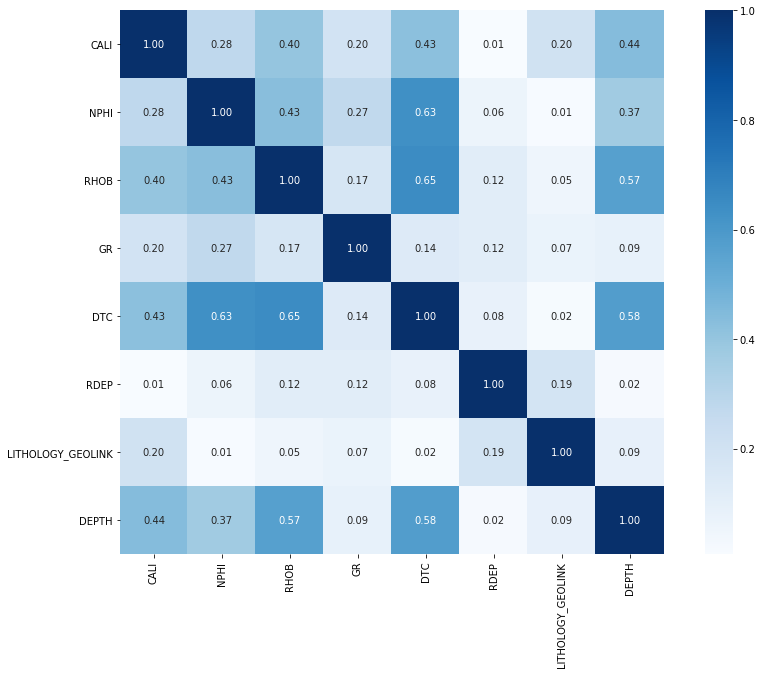

In [12]:
corrmat_litho = abs(litho_data.corr()) # absolute correlation

plt.figure(figsize=(15,10))

sns.heatmap(corrmat_litho, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, cmap='Blues')

    * Dataset Creation

In [13]:
from sklearn.model_selection import train_test_split

X = litho_data.drop(columns='LITHOLOGY_GEOLINK')

Y = litho_data['LITHOLOGY_GEOLINK'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=42) # close to the tabnet training dataset size

In [14]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (647357, 7) (647357,)
### Test Dataset: ###  (647358, 7) (647358,)


    * Model Selection

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, cross_validate

class_pipelines = []

class_pipelines.append(('ScaledRidge', Pipeline([('Scaler', RobustScaler()),('Ridge', linear_model.RidgeClassifier())])))
class_pipelines.append(('ScaledSGDCls', Pipeline([('Scaler', RobustScaler()),('SGDCls', linear_model.SGDClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledKNNCls', Pipeline([('Scaler', RobustScaler()),('KNNCls', KNeighborsClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledDTC', Pipeline([('Scaler', RobustScaler()),('DTC', DecisionTreeClassifier())])))
class_pipelines.append(('ScaledRFC', Pipeline([('Scaler', RobustScaler()),('RFC', RandomForestClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledADA', Pipeline([('Scaler', RobustScaler()),('ADA', AdaBoostClassifier())])))


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, make_scorer

results = []

names = []

for name, model in tqdm_notebook(class_pipelines, desc='Cross-Validation Procedure'):

    kfold = KFold(n_splits=5, random_state=42)

    scorers = {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score), 'precision': make_scorer(precision_score, average='micro'), 'recall': make_scorer(recall_score, average='micro'), 'f1': make_scorer(f1_score, average='weighted')}

    final_scorers = cross_validate(model, x_train, y_train, cv=kfold, scoring=scorers)
    results.append(final_scorers)
    names.append(name)
    print(name, 'Acc: ', final_scorers['test_accuracy'].mean(), '\\', final_scorers['test_accuracy'].std(), '\n')
    print(name, 'BalAcc: ', final_scorers['test_balanced_accuracy'].mean(), '\\', final_scorers['test_balanced_accuracy'].std(), '\n')
    print(name, 'F1: ', final_scorers['test_f1'].mean(), '\\', final_scorers['test_f1'].std(), '\n')


ScaledRidge Acc:  0.3402465713502307 \ 0.00037679329858468025 

ScaledRidge BalAcc:  0.11901317503051076 \ 0.0008315326991997377 

ScaledRidge F1:  0.26737772507204594 \ 0.00035719279349502565 

ScaledSGDCls Acc:  0.30565360559914145 \ 0.018314841842569998 

ScaledSGDCls BalAcc:  0.15261777495360215 \ 0.011912209066169438 

ScaledSGDCls F1:  0.2733292239907247 \ 0.01598958274218404 

ScaledKNNCls Acc:  0.7698997608697697 \ 0.0011817111638493941 

ScaledKNNCls BalAcc:  0.7075689316237905 \ 0.003086875844284442 

ScaledKNNCls F1:  0.7687491224342721 \ 0.0011540725575414602 

ScaledDTC Acc:  0.7525831935448546 \ 0.0016564646930133273 

ScaledDTC BalAcc:  0.7583661884304869 \ 0.010914574727905479 

ScaledDTC F1:  0.7525051848485299 \ 0.0016203484936691255 

ScaledRFC Acc:  0.8429182038474154 \ 0.0009519069528153707 

ScaledRFC BalAcc:  0.8325353065456056 \ 0.01293992443013883 

ScaledRFC F1:  0.8418514267173813 \ 0.0009142104114019913 

ScaledADA Acc:  0.3230211651965661 \ 0.00714946979856

    * Hyperparameter Tunning

In [17]:
start_time = time.time()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc = RandomForestClassifier(n_jobs=60)

kfold = KFold(n_splits=5, random_state=42)

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = kfold, verbose=10, random_state=42, scoring='balanced_accuracy')

rfc_random.fit(RobustScaler().fit_transform(x_train), y_train)

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 


_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, score=0.834, total= 1.3min
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, score=0.822, total= 1.3min
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, score=0.836, total= 1.3min
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, score=0.815, total= 1.0min
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_

In [18]:
result_cv = pd.DataFrame.from_dict(rfc_random.cv_results_)

result_cv.to_csv('../models/results/rand_search_rfc.csv')

    * Model Accuracy Test

In [30]:
start_time = time.time()

#best_rfc = RandomForestClassifier(max_depth=40, n_estimators=1400, max_features='auto', min_samples_split=2, bootstrap=False, n_jobs=60) # the rest of the best parameters are  the default ones

best_rfc = rfc_random

y_predict = best_rfc.predict(RobustScaler().fit_transform(x_test))

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

0.7 minutes taken


In [31]:
print('Accuracy: ', str(accuracy_score(y_test, y_predict)), '\n')
print('########################', '\n')
print('Balanced Accuracy: ', str(balanced_accuracy_score(y_test, y_predict)))
print('########################', '\n')
print('F1-Score Micro: ', str(f1_score(y_test, y_predict, average='weighted')))

Accuracy:  0.8596896925657828 

######################## 

Balanced Accuracy:  0.8489341931606508
######################## 

F1-Score Micro:  0.8588929458538379


    * Confusion Matrix

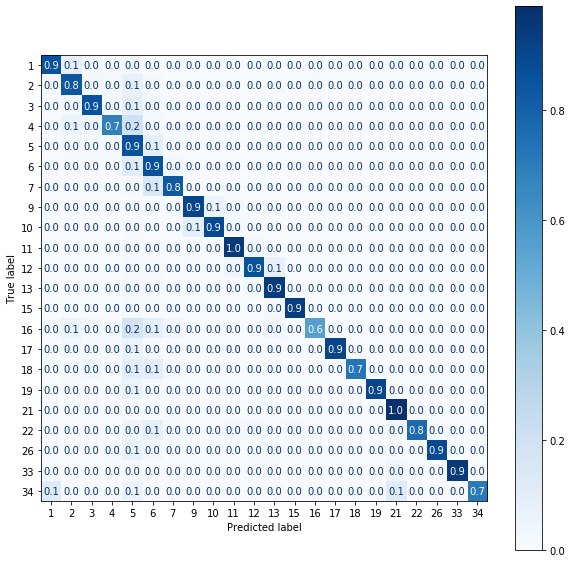

In [32]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(best_rfc, RobustScaler().fit_transform(x_test), y_test, normalize='true', cmap=plt.cm.Blues, ax=ax, values_format='.1f')

plt.show()

    * Null Values Prediction

        * Null Values Dataset 

In [ ]:
null_litho_dataset = total_df[pd.isnull(total_df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME', 'LITHOLOGY_GEOLINK'])

        * Prediction

In [ ]:
litho_prediction = best_rfc.predict(RobustScaler().fit_transform(null_litho_dataset))

        * Replacing Null Values for Predicted Ones

In [ ]:
predicted_litho_dataset = null_litho_dataset

predicted_litho_dataset['LITHOLOGY_GEOLINK'] = litho_prediction

predicted_litho_dataset.head(n=5)

    * Final Dataframe

In [ ]:
final_df = litho_data.append(predicted_litho_dataset)

final_df.sort_index(inplace=True)

final_df['WELL_NAME'] = total_df['WELL_NAME'].values

final_df.head(n=5)

# Checkpoints

In [ ]:
path_file_final_df = '../checkpoints/final_df.csv.gz'

final_df.to_csv(path_file_final_df,index=False, compression='gzip')